# Evaluation de l'UE Prog

*Auguste Gardette et Judith Coutrot*

AgroParisTech - IODAA 

## Jeu de données : Muti-classification de données - Fetal Health disease detection

Travail d'évaluation de l'UE programmation dont le but est de mettre en avant:

- Différentes tâches supervisées: classification, régression
- Optimisation des performances (sélection de modèles, de caractéristiques, optimisation des pré-traitement)
- Présentation des performances de référence par rapport aux performances optimisées
- Modèles scikit-learn + approches deep-learning

Données issues du site Kaggle (https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

### Préambule

In [26]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


### **1. Introduction des données**

#### Introduction et chargement des données

**Contexte :**

Le jeu de données sur lequel nous avons choisi de travailler porte sur la **détection de maladies fœtales**. Celle ci constistitue un enjeu majeur dans la prévention de maladies infantiles dont la réduction est prise en compte dans plusieurs des objectifs de développement durable des Nations Unies et constitue un indicateur clé du progrès humain.

Les **cardiotocogrammes** (CTG) représentent une option simple et accessible en termes de coûts pour évaluer la santé du fœtus, ce qui permet aux professionnels de la santé de prendre des mesures afin de prévenir la mortalité infantile et maternelle. Le cardiotacographe fonctionne en envoyant des impulsions ultrasonores et en lisant la réponse, ce qui permet de mettre en lumière le rythme cardiaque fœtal, les mouvements du fœtus, les contractions utérines...

**Données :**

Cet ensemble de données contient 2126 enregistrements de caractéristiques extraites d'examens de cardiotocogramme, qui ont ensuite été classés par trois obstétriciens experts en trois classes :

- Normal (1)
- Suspect (2)
- Pathologique (3)

> <span style="color:green"> Le but du travail présenté est donc de produire un modèle de classification (multiple) capable de prédire si les résultats du CTG présagent d'une maladie foetale. Pour ce faire, nous nous tournons vers plusieurs techniques de machines learning que nous comparons.</span>

In [3]:
#Chargement des données
data = pd.read_csv("fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [7]:
print("Nombre d'exemples : ", data.shape[0])
print("Nombre de features (caractéristiques du CTG) : ", data.shape[1])
print("Classes cibles : ", data['fetal_health'].unique())

Nombre d'exemples :  2126
Nombre de features (caractéristiques du CTG) :  22
Classes cibles :  [2. 1. 3.]


#### Visualisation des données

[Text(0, 0, 'Normal'), Text(1, 0, 'Suspect'), Text(2, 0, 'Pathologique')]

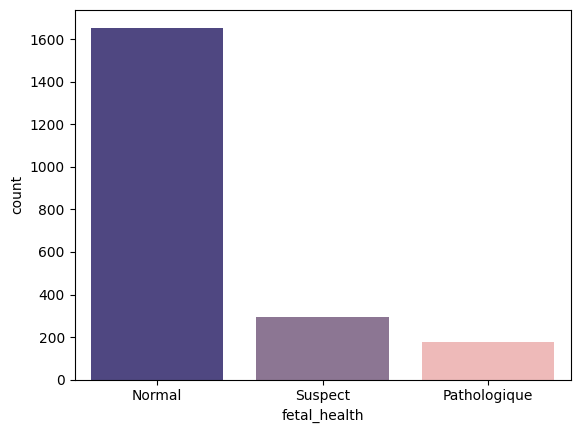

In [23]:
colours=["#483D8B","#8f7198", "#f7b2b0"]
ax = sns.countplot(data= data, x="fetal_health",palette=colours)
ax.set_xticklabels(['Normal', 'Suspect', 'Pathologique'])

Il y a un déséquilibre dans le nombre d'exemples de chaque classe : peu surprenant (fort heureusement) étant donné que la majorité des grossesses se passent bien. (Grande majorité de `Normal` face aux CTG `Supespects` et  `Pathologiques`). Ce déséquilibre sera toutefois à prendre en compte dans l'interprétation des résultats.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


**Features :**

- **`baseline value`** Valeur de base du FHR (*Fetal Heart Rate*, battements par minute)
- **`accelerations`** Nombre d'accélérations par seconde
- **`fetal_movement`** Nombre de mouvements fœtaux par seconde
- **`uterine_contractions`** Nombre de contractions utérines par seconde
- **`light_decelerations`** Nombre de décélérations légères par seconde
- **`severe_decelerations`** Nombre de décélérations sévères par seconde
- **`prolonged_decelerations`** Nombre de décélérations prolongées par seconde
- **`abnormal_short_term_variability`** Pourcentage de temps avec une variabilité anormale à court terme
- **`mean_value_of_short_term_variability`** Valeur moyenne de la variabilité à court terme
- **`percentage_of_time_with_abnormal_long_term_variability`** Pourcentage de temps avec une variabilité anormale à long terme.
- **`mean_value_of_long_term_variability`** Valeur moyenne de la variabilité à long terme 
- **`histogram_width`** Largeur de l'histogramme du FHR
- **`histogram_min` Minimum** (basse fréquence) de l'histogramme du FHR
- **`histogram_max` Maximum** (haute fréquence) de l'histogramme du FHR
- **`histogram_number_of_peaks`** Nombre de pics de l'histogramme
- **`histogram_number_of_zeroes`** Nombre de zéros de l'histogramme
- **`histogram_mode`** Mode d'histogramme
- **`histogram_mean`** Moyenne de l'histogramme
- **`histogram_median`** Médiane de l'histogramme
- **`histogram_variance`** Variance de l'histogramme
- **`histogram_tendency`** Tendance de l'histogramme

**Target :**
- **`fetal_health`** Étiqueté 1 (normal), 2 (suspect) et 3 (pathologique)



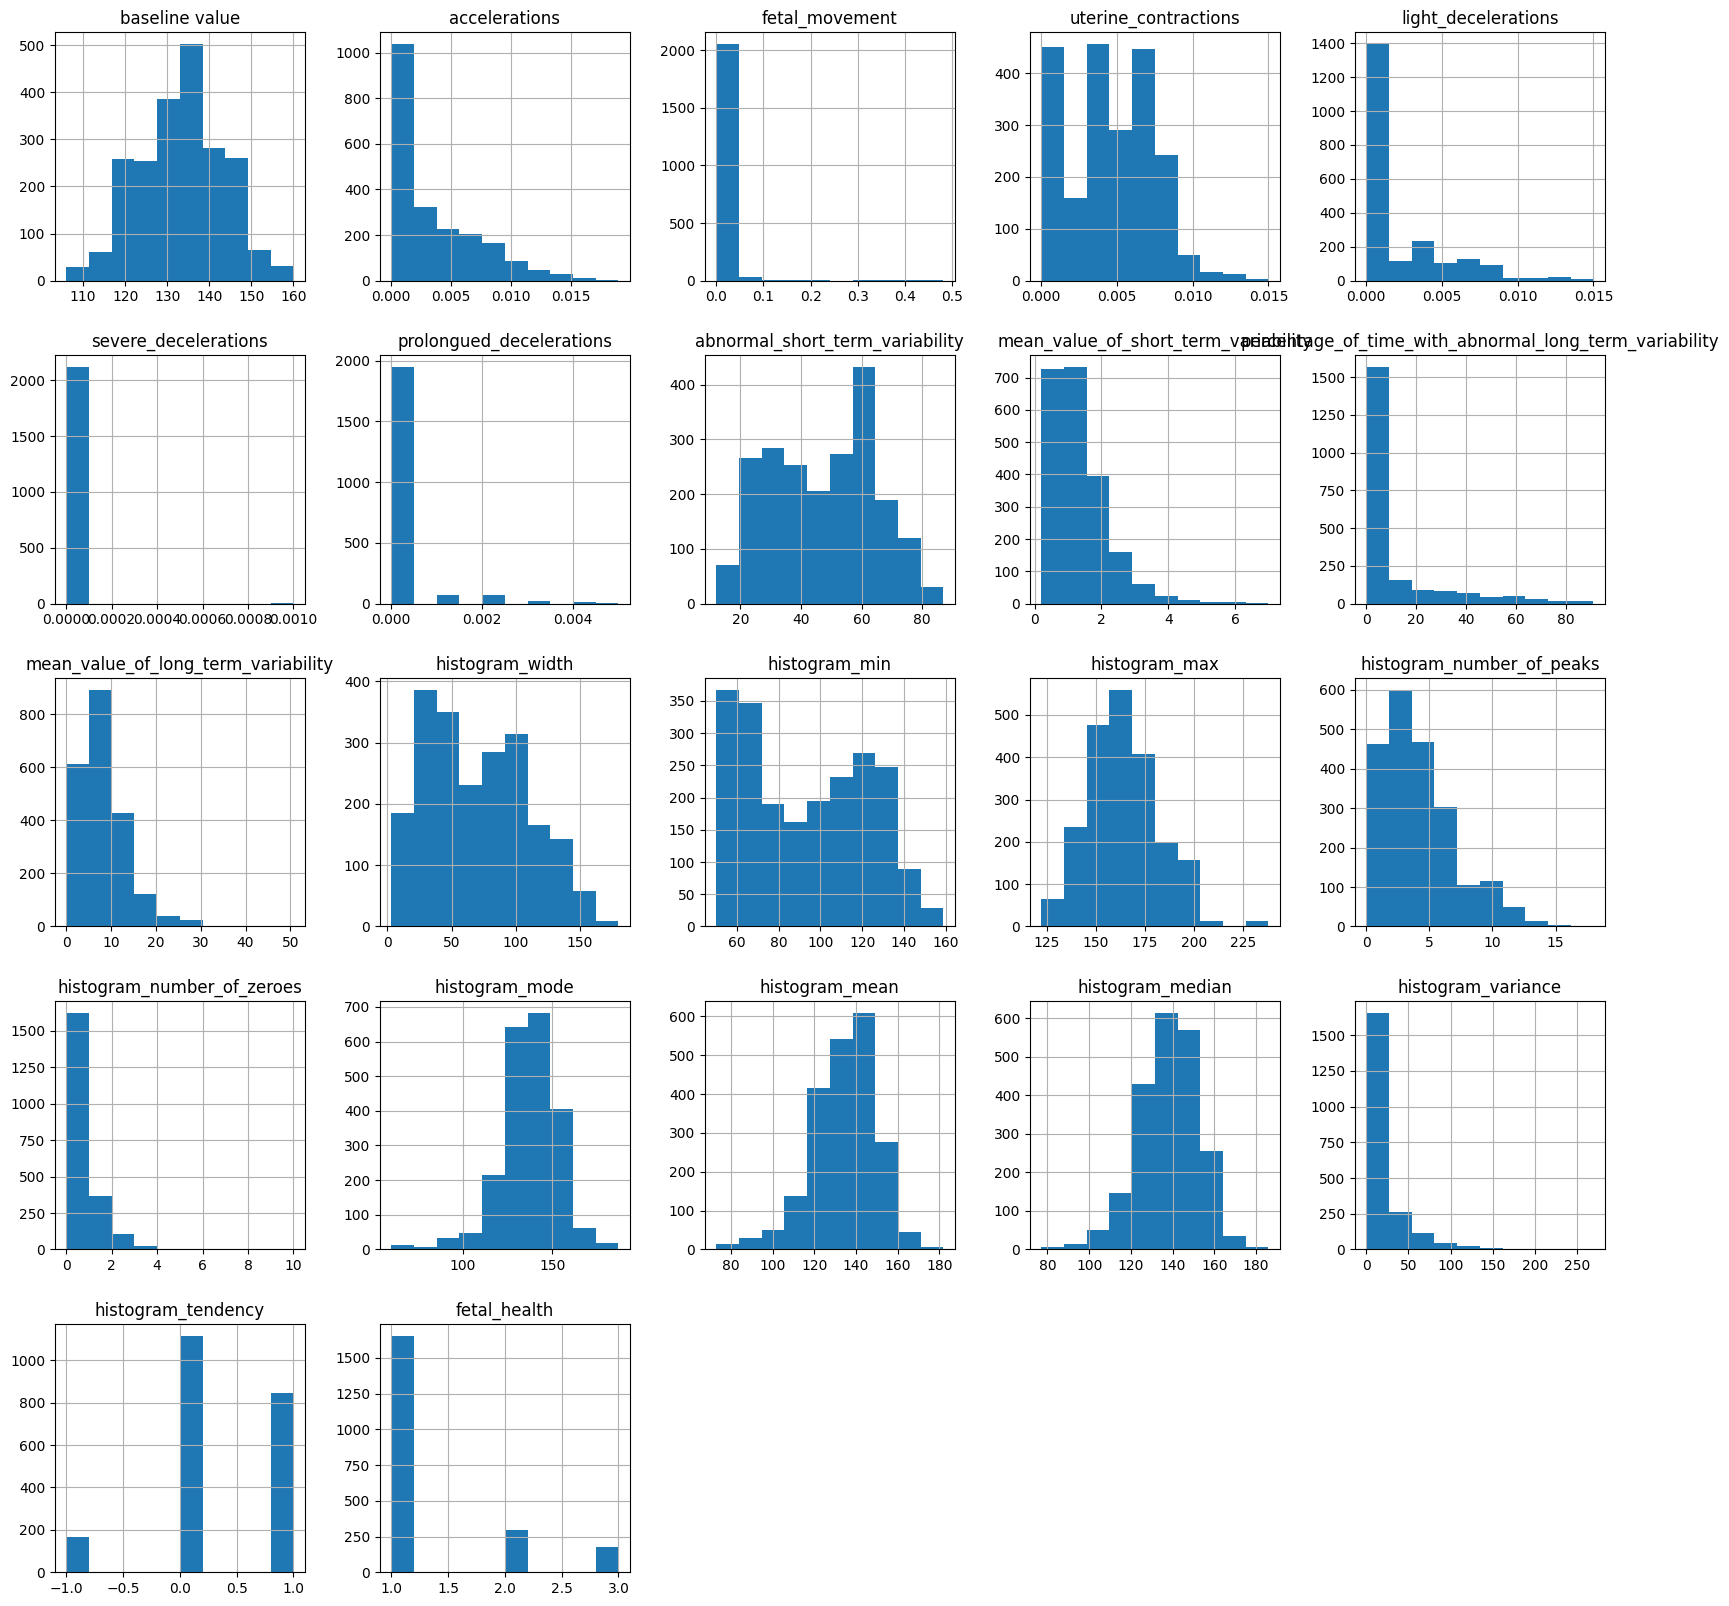

In [62]:
# Evaluating distributions of the features 
hist_plot = data.hist(figsize = (20,20)) #, color = "#483D8B")

Plusieurs choses sont à relever de ces graphiques : 
- Les variables discrètes (comme `fetal_health`) sont encodées numériquement, ce travail n'est donc pas à faire manuellement.
- Plusieurs *features* (notamment liées à l'`histogramme` du *Feta Heart Rate*) ont des distributions gaussiennes. 
- Certaines *features* ont des valeurs faibles, voir nulles, à l'exeption de quelques valeurs hautes (notamment `severe_desceleration` ou `fetal_movement`).

En raison de leur nature médicale, nous avons choisi de ne pas normaliser les données par individu.

<Axes: >

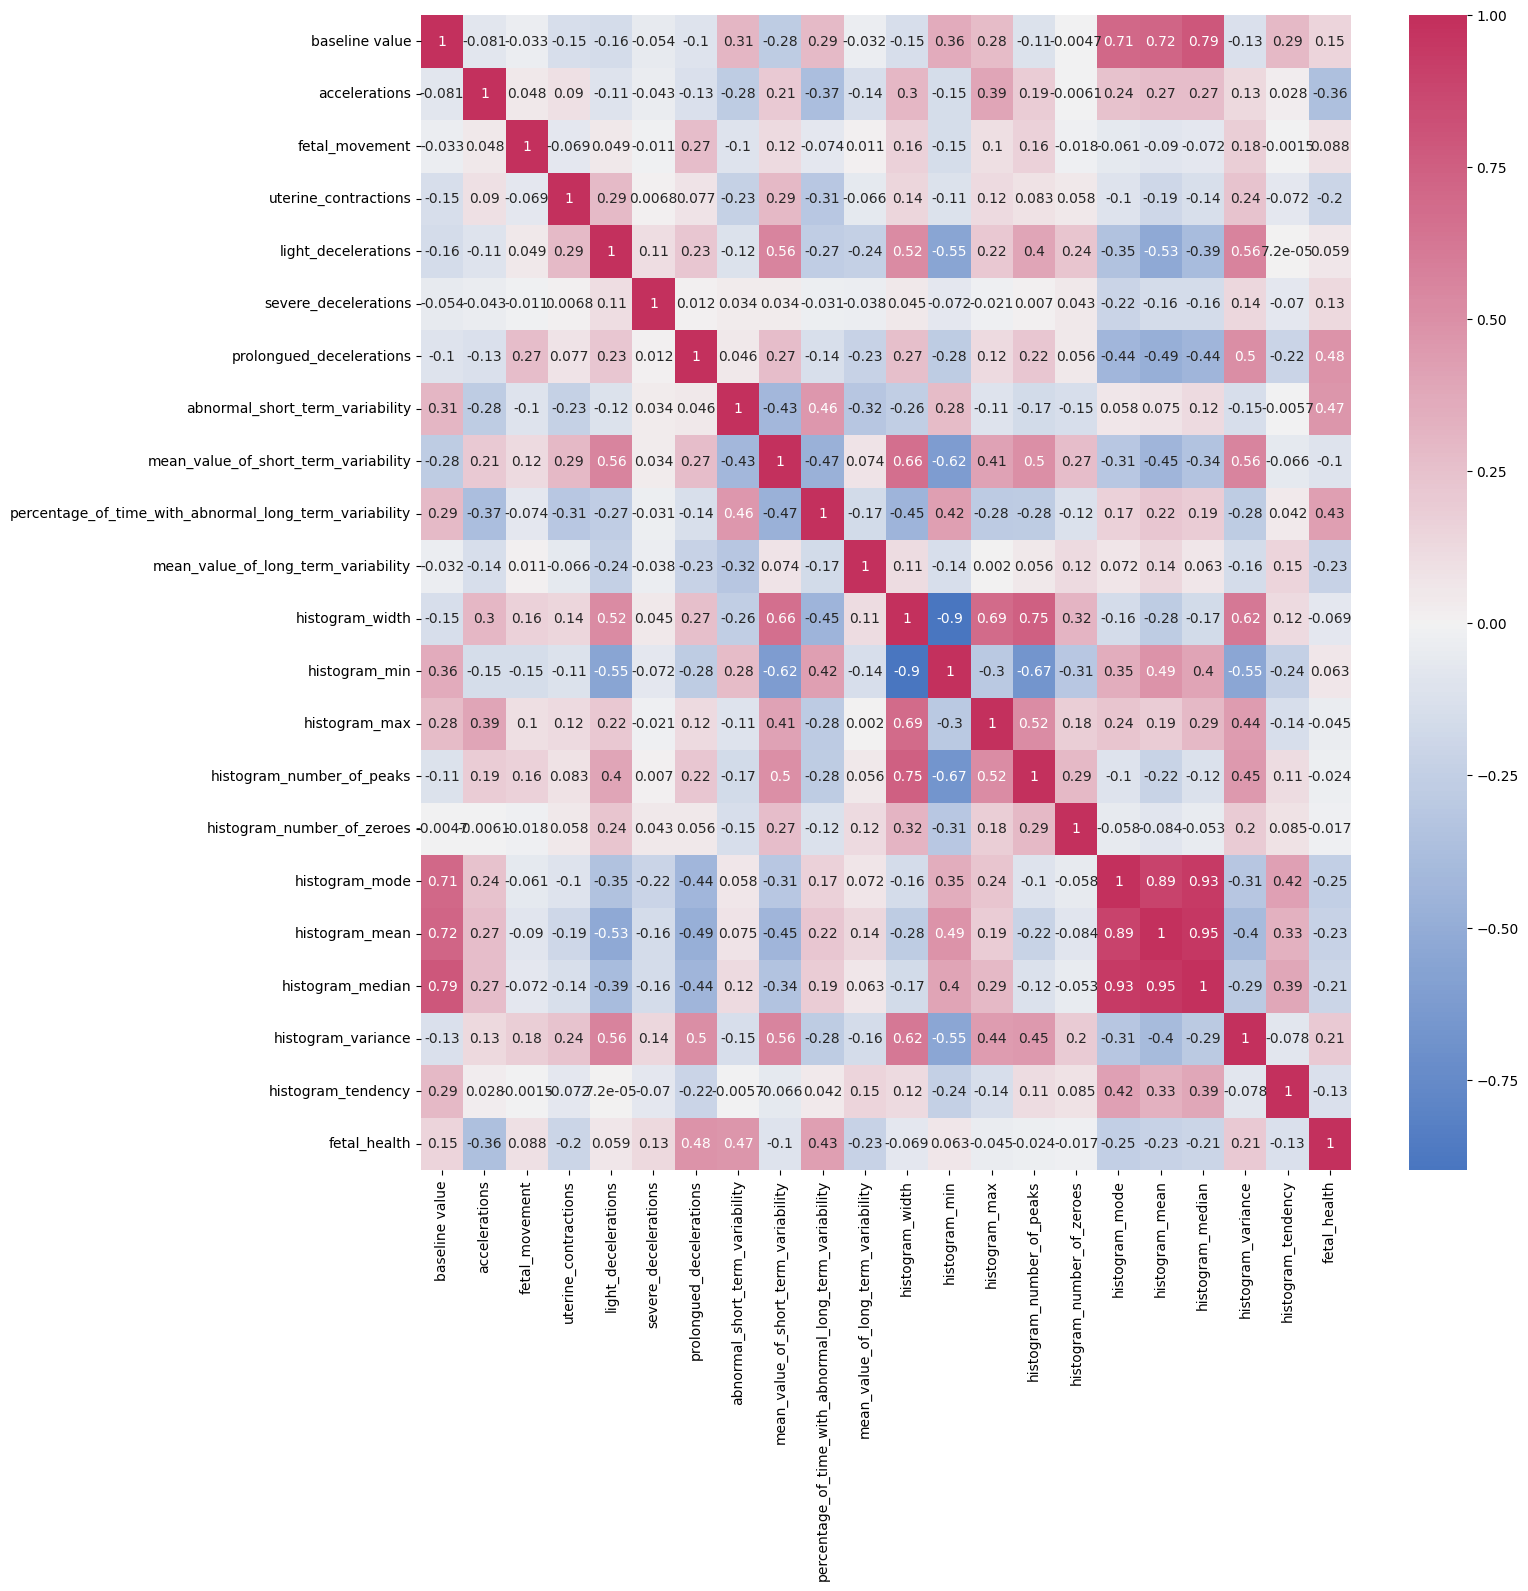

In [41]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(15,15))  

cmap = sns.diverging_palette(255, 0, s=80, l=45, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)


<span style="color:#483D8B;"> A première vue, avec la matrice de corrélation, les *features* `prolonged_decelerations`, `abnormal_short_term_variability` et `percentage_of_time_with_abnormal_long_term_variability` et `histogram_variance` sont positivement corrélées à `fetal_health`. Cela signifie qu'une valeur élevée de ces variables est liée à une augmantation durisque de pathologie foetale. Au contraire, `accelerations`, `uterine_contractions`, `mean_value_of_long_term_variability`, `histogram_mode`, `histogram_mean` et `histogram_median` sont anti-corrélées à `fetal_health`. Il porrait être intéressant de sélectionner ces variables pour éliminer du bruit.</span>

A noter que les variables  `histogram_mode`, `histogram_mean` et `histogram_median` sont très corrélées, tout comme  `histogram_width` et `histogram_mean` sont fortement anti-corrélées. 

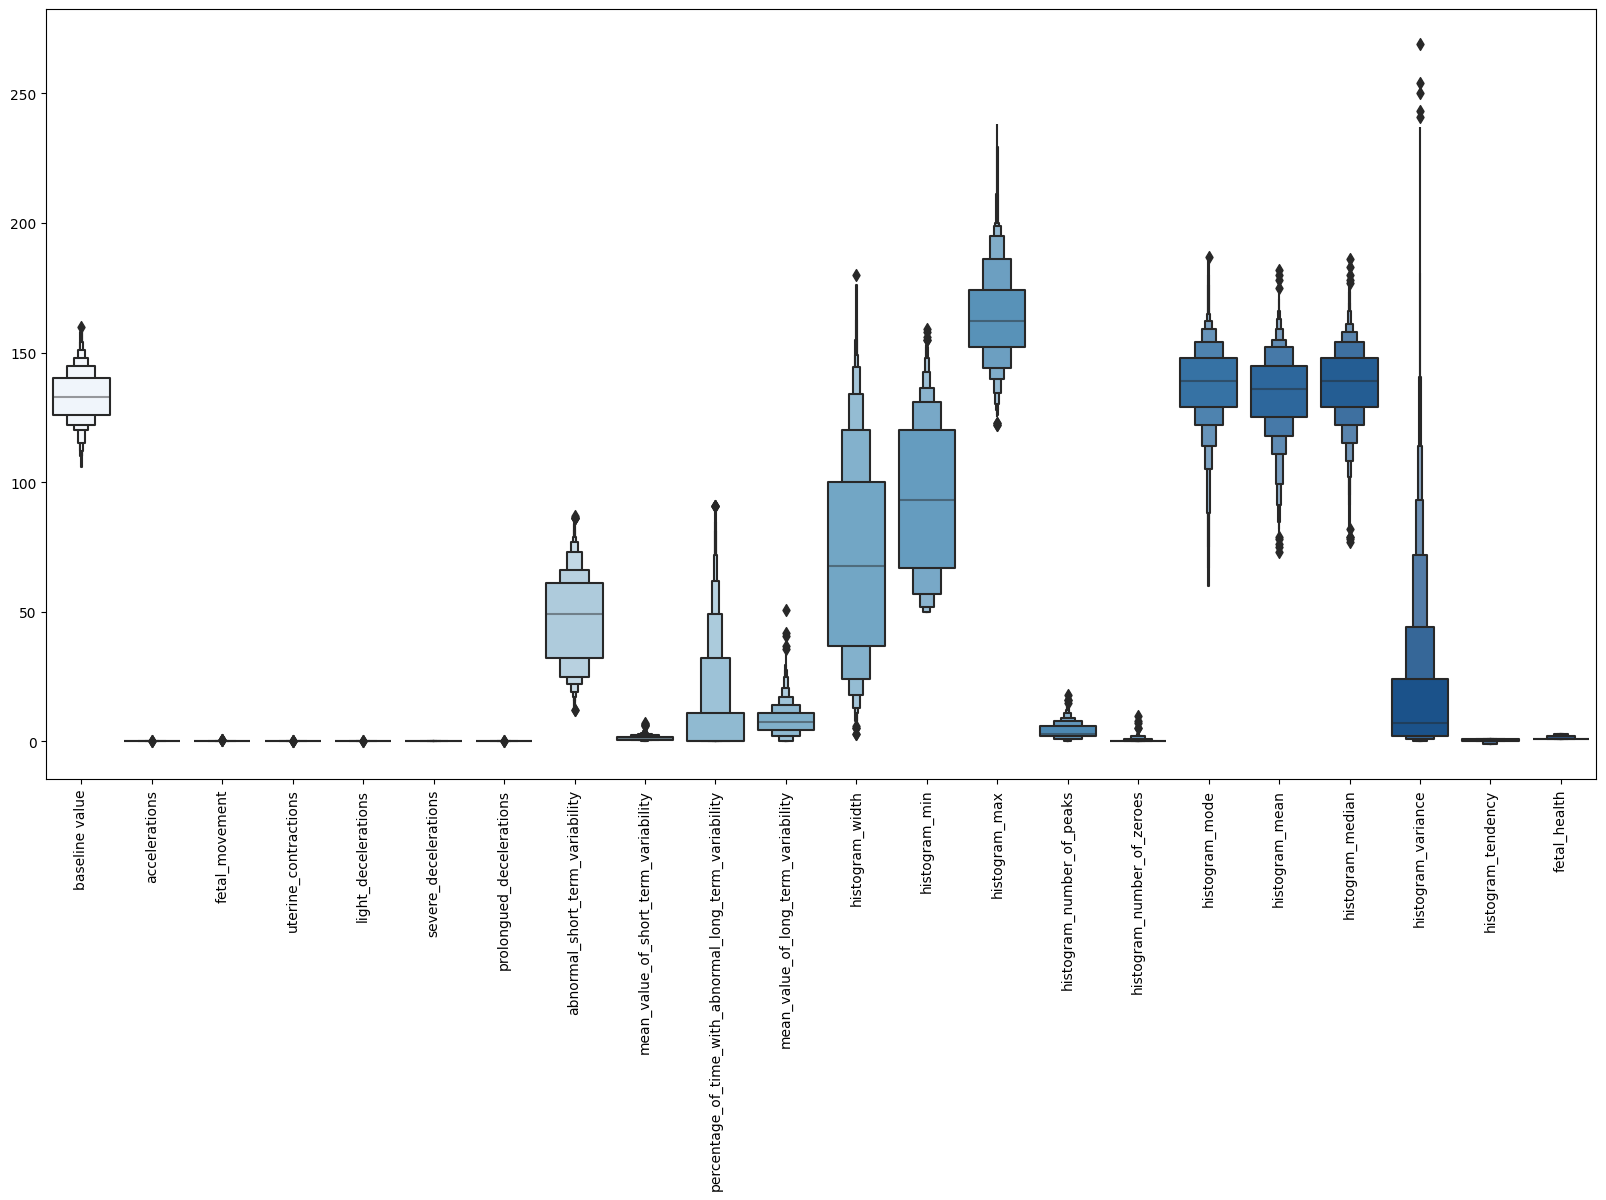

In [59]:
#Plotting the scaled features using boxen plots
plt.figure(figsize=(20,10))
sns.boxenplot(data = data, palette = 'Blues')
plt.xticks(rotation=90)
plt.show()

<span style="color:#483D8B;"> Les ordres de grandeurs des variables sont très différents, il pourra être intéressant de les normaliser pour améliorer le modèle. </span>

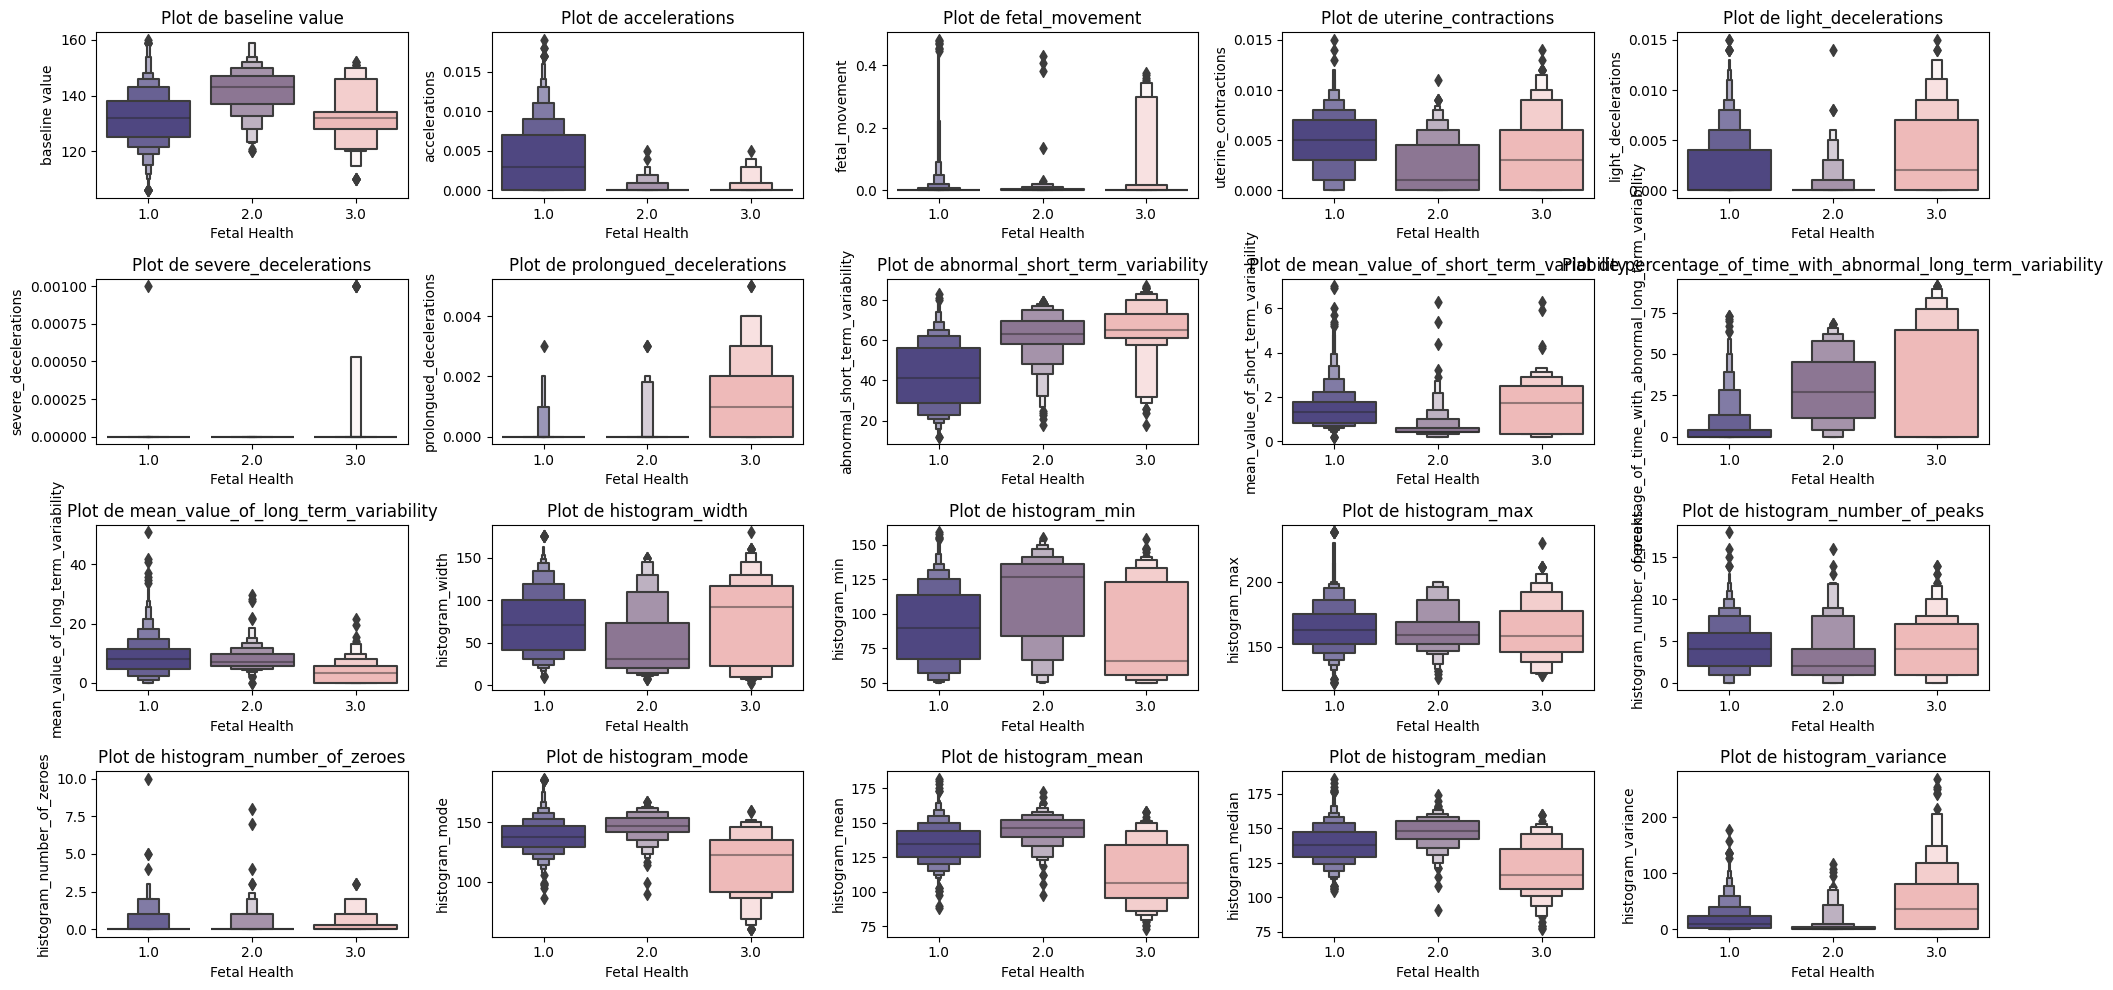

In [60]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20, 10))
cols = data.drop(["histogram_tendency","fetal_health"],axis=1)
colours=["#483D8B","#8f7198", "#f7b2b0"]

for i, col in enumerate(cols):
    # sns.swarmplot(x=data["fetal_health"], y=data[i], color="black", alpha=0.5 )
    # sns.boxenplot(x=data["fetal_health"], y=data[i], palette=colours)
    
    #sns.swarmplot(x=data["fetal_health"], y=data[col], color="black", alpha=0.5, ax=axs[i//5][i%5])
    sns.boxenplot(x=data["fetal_health"], y=data[col], palette=colours, ax=axs[i//5][i%5])
    axs[i//5][i%5].set_title('Plot de '+col)
    axs[i//5][i%5].set_xlabel('Fetal Health')
    axs[i//5][i%5].set_ylabel(col)

# Ajustement de l'espacement entre les subplots
plt.tight_layout()

# Affichage de la figure
plt.show()

<span style="color:#483D8B;">Ces graphiques permettent de repérer quelques valeurs *outliers* qu'on ne souhaite pas retirer dans un premier temps pour éviter de favoriser le surapprentissage. Il pourrait être interessant de les enlever pour les finitions d'un modèle. </span>

#### Amélioration possible des prétraitements des données

In [71]:
#assigning values to features as X and target as y
X=data.drop(["fetal_health"],axis=1)
y=data["fetal_health"]

<span style="color:#483D8B;">Comme évoqué précédemment nous procédons à une normalisation des données par colonne. </span>

**Normalisation des données (par colonne) :**

In [72]:
#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_norm= s_scaler.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=col_names)   
X_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


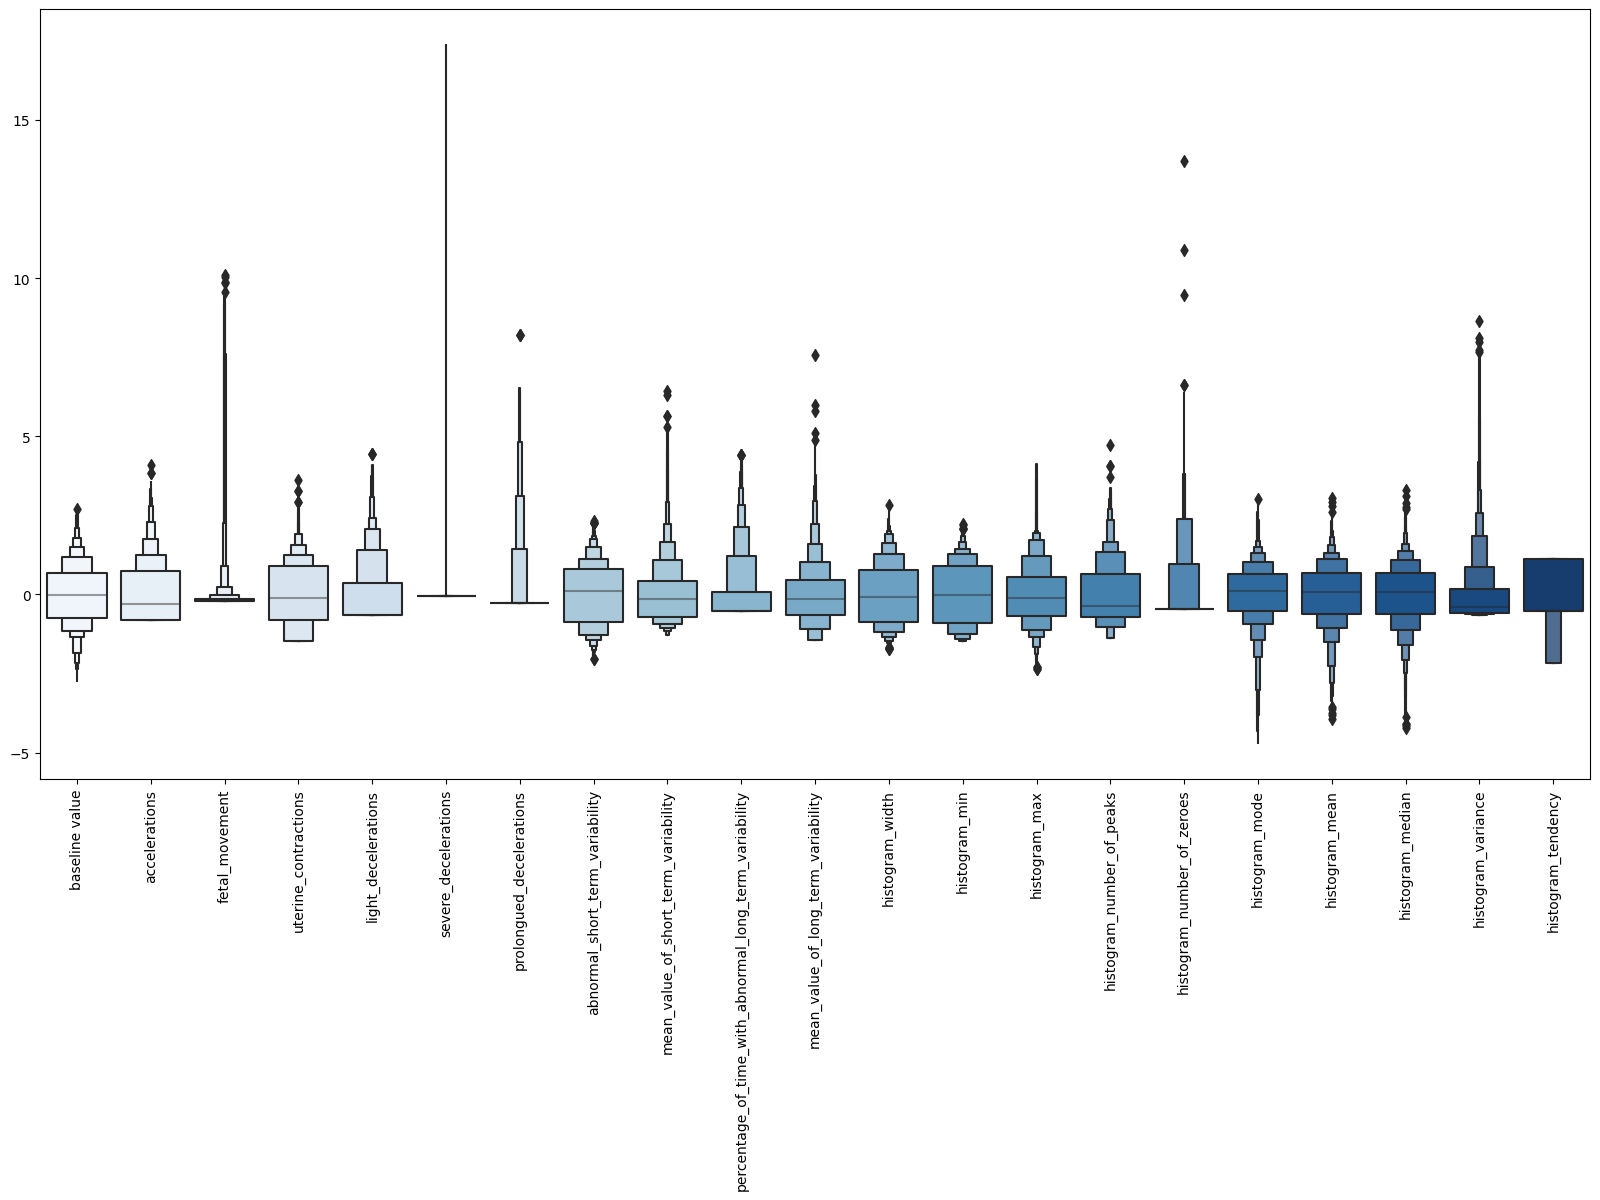

In [73]:
#Plotting the scaled features using boxen plots
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_norm, palette = 'Blues')
plt.xticks(rotation=90)
plt.show()

#### Mise en forme des données d'entrainement et de test

In [87]:
y[y==1] = 0
y[y==2] = 1
y[y==3] = 2

In [88]:
y.unique()

array([1., 0., 2.])

In [91]:
#spliting test and training sets
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=30)
X_train_norm, X_test_norm, y_train_norm,y_test_norm = train_test_split(X_norm,y,test_size=0.3,random_state=30)

### **2. Modèles**

In [82]:
modeles = [LogisticRegression(), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()] 

In [200]:
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression())])
pipeline_svc=Pipeline([('sv_classifier',SVC())])
pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=42))])
pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_xgb=Pipeline([('xgb_classifier',XGBClassifier())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_svc, pipeline_dt, pipeline_rf, pipeline_xgb]
pipe_dict = ['Logistic Regression', "SVC", 'Decision Tree', 'RandomForest', 'XGB']

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#cross validation on accuracy 
sc_List = []
sc_List_norm = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, scoring='accuracy')
    cv_score_norm = cross_val_score(model, X_train_norm,y_train_norm, scoring='accuracy')
    sc_List.append(cv_score)
    sc_List_norm.append(cv_score_norm)
    print("Accuracy %s: %f " % (pipe_dict[i], cv_score.mean()))
    print("Accuracy (données normalisées) %s: %f " % (pipe_dict[i], cv_score_norm.mean()))


c:\Users\judit\OneDrive\Documents\IODAA_progra\pytorch\session\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\judit\OneDrive\Documents\IODAA_progra\pytorch\session\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Accuracy Logistic Regression: 0.862208 
Accuracy (données normalisées) Logistic Regression: 0.891135 
Accuracy SVC: 0.850116 
Accuracy (données normalisées) SVC: 0.908594 
Accuracy Decision Tree: 0.903894 
Accuracy (données normalisées) Decision Tree: 0.905238 
Accuracy RandomForest: 0.936142 
Accuracy (données normalisées) RandomForest: 0.933462 
Accuracy XGB: 0.943538 
Accuracy (données normalisées) XGB: 0.943538 


<span style="color:#483D8B;"> Tout d'abord la normalisation appliquée ne joue pas un rôle majeur dans les performances de la tâche de classification des CTG, bien qu'elle fasse différer l'*accuracy* pour certains modèles nortamment la Régression Logistique et  la Forêt aléatoire. Le modèle qui a la plus haute accuracy est sans surprise **XGBoost**.</span>

### **3. Choix des meilleurs paramètres**

In [102]:
parameters = {"learning_rate": [0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75], 
              "n_estimators": [100, 200, 350, 500, 750],
              "max_depth": [3, 5, 7, 9]
              }

In [103]:
GridSearchCV_gbcl = GridSearchCV(estimator=XGBClassifier(), 
                                param_grid=parameters,
                                scoring="accuracy", 
                                return_train_score=True
                                )

In [104]:
GridSearchCV_gbcl.fit(X_train, y_train)

In [105]:
best_parameters = GridSearchCV_gbcl.best_params_
print(f"Best parameters for the model:\n{best_parameters}")

Best parameters for the model:
{'learning_rate': 0.075, 'max_depth': 9, 'n_estimators': 350}


### **4. Evaluation du modèle**

In [106]:
# Testing with the best parameters, 

gbcl = XGBClassifier(learning_rate=0.075,max_depth=9, n_estimators=350)

gbcl_mod = gbcl.fit(X_train, y_train)
pred_gbcl = gbcl_mod.predict(X_test)

#### Prédiction sur les données de test

In [107]:
acccuracy = metrics.accuracy_score(y_test, pred_gbcl)
recall = metrics.recall_score(y_test, pred_gbcl, average="weighted")
precision = metrics.precision_score(y_test, pred_gbcl, average="weighted")
f1_score = metrics.f1_score(y_test, pred_gbcl, average="micro")

print("Accuracy    : ", acccuracy)
print("Recall      : ", recall)
print("Precision   : ", precision)
print("F1 Score    : ", f1_score)

Accuracy    :  0.9498432601880877
Recall      :  0.9498432601880877
Precision   :  0.9484493578923288
F1 Score    :  0.9498432601880877


<span style="color:#483D8B;">Les scores sont relativement hauts mais dans le milieu médicale il serait peut-être intéressant de privilégier certains scores plutôt que d'autres, pour avoir par exemple un rappel très important. </span>

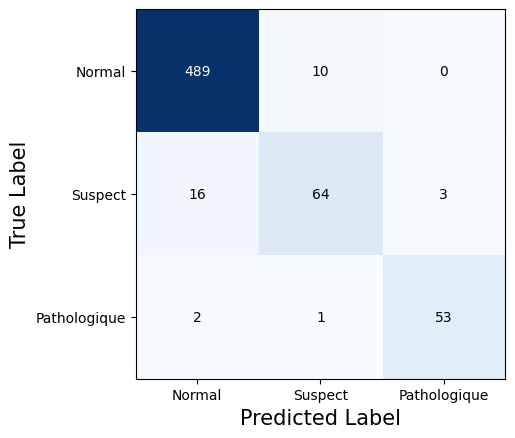

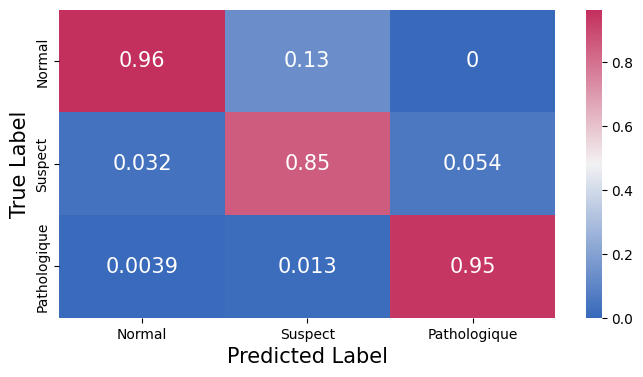

In [201]:
# cofusion matrix
from mlxtend.plotting import plot_confusion_matrix

cf_matrix = metrics.confusion_matrix(y_test, pred_gbcl)
plot_confusion_matrix(cf_matrix,cmap=plt.cm.Blues) #figsize=(12,8)
plt.xticks(range(3), ['Normal', 'Suspect', 'Pathologique'], fontsize=10)
plt.yticks(range(3), ['Normal', 'Suspect', 'Pathologique'], fontsize=10)
plt.xlabel('Predicted Label',fontsize=15)
plt.ylabel('True Label',fontsize=15)
plt.show()

plt.subplots(figsize=(8,4))
axs = sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=0), cmap=cmap,annot = True, annot_kws = {'size':15})
axs.set_xticklabels(['Normal', 'Suspect', 'Pathologique'], fontsize=10)
axs.set_yticklabels(['Normal', 'Suspect', 'Pathologique'], fontsize=10)
axs.set_xlabel('Predicted Label',fontsize=15)
axs.set_ylabel('True Label',fontsize=15)
plt.show()

<span style="color:#483D8B;">Dans la première matrice, nous avons **les nombres exactes d'exemples bien classés et mal classés** selon leur classe. Dans la seconde matrice, ces chiffres ont été normalisés en fonction du nombre de labels prédits. Ainsi lorsqu'il a été prédit `Normal` 96% du temps le CTG l'était, 3.2% du temps il était en réalité  `Suspect` et 0.39% du temps il était en fait `Pathologique`. Ces résultats sont plutôt cohérents : le modèle confond peu `Normal`et `Pathologique`. En revanche, le modèle a plus de difficulté à classer les `Suspects`qu'il a tendance à classer comme `Normal`.</span>

Dans la suite de ce travail, nous nous somme tourné vers le un réseau de neurone pour classer ces CTG.

### **5. Multi Layer Perceptron**

In [245]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tensorboard import notebook

from torch.utils.tensorboard import SummaryWriter
import time
import os

TB_PATH = "C:/Users/judit/OneDrive/Documents/IODAA_progra/pytorch/tmp/logs/module2"
PATH = "C:/Users/judit/OneDrive/Documents/IODAA_progra/pytorch/Fetal_Health/model/"

use_cuda = torch.cuda.is_available()
print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

La version de torch est :  2.0.0+cpu
Le calcul GPU est disponible ?  False
cpu


In [246]:
import torch.nn as nn
from tqdm import tqdm

In [247]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [248]:
# fonctions de checkpointing

def save_state(epoch,model,optim,fichier):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch

In [249]:
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).double().mean()
    
def train(model,epochs,train_loader,test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.SGD(model.parameters(),lr=1e-5)    # choix optimizer
    model = model.to(device)
    history_train_loss = []
    history_test_loss = []
    history_train_acc = []
    history_test_acc = []
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                          
    for epoch in tqdm(range(epochs)):
        #print(f"Epoch {epoch} :")
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x,y in train_loader:                            
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        #print(f"TRAIN -    Loss {cumloss/count},      Accuracy {cumacc/count} ")
        if epoch % 1000 == 0:
            history_train_loss.append(cumloss/count)
            history_train_acc.append(cumacc/count)
            fichier = PATH+f"{model.name}"
            save_state(epoch,model,optim,fichier)
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x,y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)
                print(f"Epoch : {epoch} : TEST -    Loss {cumloss/count},      Accuracy {cumacc/count} ")
                history_test_loss.append(cumloss/count)
                history_test_acc.append(cumacc/count)
    return history_train_loss, history_train_acc, history_test_loss, history_test_acc

In [250]:
BATCH_SIZE = 16

# Define the data loaders
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train.values), torch.Tensor(y_train.values).long())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test.values), torch.Tensor(y_test.values).long())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [251]:
mlp=MLP(21, 10, 6, 3).to(device)
mlp.name="1stMLP-"+ time.asctime().replace(' ', '_').replace(':', '-')

In [252]:
EPOCH = 30000
tensor_acc_loss = train(mlp,EPOCH,train_loader,test_loader)

running 1stMLP-Tue_Apr_18_20-54-26_2023


  0%|          | 1/30000 [00:00<50:47,  9.84it/s]

Epoch : 0 : TEST -    Loss 0.7817107439041138,      Accuracy 0.7789968652037618 


  3%|▎         | 1003/30000 [01:09<35:41, 13.54it/s]

Epoch : 1000 : TEST -    Loss 0.5294371843338013,      Accuracy 0.7978056426332288 


  7%|▋         | 2002/30000 [04:03<1:39:25,  4.69it/s]

Epoch : 2000 : TEST -    Loss 0.4969971776008606,      Accuracy 0.7962382445141066 


 10%|█         | 3002/30000 [06:27<1:17:21,  5.82it/s]

Epoch : 3000 : TEST -    Loss 0.4732251763343811,      Accuracy 0.8025078369905956 


 13%|█▎        | 4002/30000 [09:15<1:14:55,  5.78it/s]

Epoch : 4000 : TEST -    Loss 0.4512171745300293,      Accuracy 0.8134796238244514 


 17%|█▋        | 5001/30000 [12:07<1:18:07,  5.33it/s]

Epoch : 5000 : TEST -    Loss 0.43476662039756775,      Accuracy 0.822884012539185 


 20%|██        | 6002/30000 [14:39<1:10:07,  5.70it/s]

Epoch : 6000 : TEST -    Loss 0.42324480414390564,      Accuracy 0.8385579937304075 


 23%|██▎       | 7001/30000 [17:43<1:18:30,  4.88it/s]

Epoch : 7000 : TEST -    Loss 0.4162684381008148,      Accuracy 0.841692789968652 


 27%|██▋       | 8002/30000 [20:24<1:05:02,  5.64it/s]

Epoch : 8000 : TEST -    Loss 0.4120810031890869,      Accuracy 0.8401253918495298 


 30%|███       | 9002/30000 [23:15<1:00:23,  5.80it/s]

Epoch : 9000 : TEST -    Loss 0.4089592695236206,      Accuracy 0.8448275862068966 


 33%|███▎      | 10002/30000 [26:04<57:25,  5.80it/s] 

Epoch : 10000 : TEST -    Loss 0.4066818356513977,      Accuracy 0.8479623824451411 


 37%|███▋      | 11002/30000 [28:55<57:17,  5.53it/s]  

Epoch : 11000 : TEST -    Loss 0.40478089451789856,      Accuracy 0.8510971786833855 


 40%|████      | 12002/30000 [31:44<53:40,  5.59it/s]

Epoch : 12000 : TEST -    Loss 0.4038744568824768,      Accuracy 0.8510971786833855 


 43%|████▎     | 13002/30000 [33:55<52:58,  5.35it/s]  

Epoch : 13000 : TEST -    Loss 0.40314754843711853,      Accuracy 0.8495297805642633 


 47%|████▋     | 14001/30000 [36:21<46:48,  5.70it/s]

Epoch : 14000 : TEST -    Loss 0.40241047739982605,      Accuracy 0.8510971786833855 


 50%|█████     | 15002/30000 [39:09<42:14,  5.92it/s]

Epoch : 15000 : TEST -    Loss 0.40190497040748596,      Accuracy 0.8510971786833855 


 53%|█████▎    | 16002/30000 [41:59<41:21,  5.64it/s]

Epoch : 16000 : TEST -    Loss 0.4007280468940735,      Accuracy 0.85423197492163 


 57%|█████▋    | 17002/30000 [44:51<40:01,  5.41it/s]

Epoch : 17000 : TEST -    Loss 0.4006231129169464,      Accuracy 0.85423197492163 


 60%|██████    | 18003/30000 [47:34<16:51, 11.86it/s]

Epoch : 18000 : TEST -    Loss 0.40075385570526123,      Accuracy 0.8526645768025078 


 63%|██████▎   | 19003/30000 [49:29<11:40, 15.69it/s]

Epoch : 19000 : TEST -    Loss 0.39936763048171997,      Accuracy 0.85423197492163 


 67%|██████▋   | 20003/30000 [50:35<12:10, 13.68it/s]

Epoch : 20000 : TEST -    Loss 0.3996295630931854,      Accuracy 0.8573667711598746 


 70%|███████   | 21003/30000 [51:44<10:54, 13.75it/s]

Epoch : 21000 : TEST -    Loss 0.39885252714157104,      Accuracy 0.85423197492163 


 73%|███████▎  | 22001/30000 [52:53<09:25, 14.14it/s]

Epoch : 22000 : TEST -    Loss 0.3987530469894409,      Accuracy 0.85423197492163 


 77%|███████▋  | 23001/30000 [54:05<20:57,  5.57it/s]

Epoch : 23000 : TEST -    Loss 0.3986872136592865,      Accuracy 0.8526645768025078 


 80%|████████  | 24002/30000 [55:20<07:16, 13.73it/s]

Epoch : 24000 : TEST -    Loss 0.3964647352695465,      Accuracy 0.8557993730407524 


 83%|████████▎ | 25002/30000 [56:31<05:59, 13.89it/s]

Epoch : 25000 : TEST -    Loss 0.3947250545024872,      Accuracy 0.8557993730407524 


 87%|████████▋ | 26002/30000 [57:41<04:45, 14.03it/s]

Epoch : 26000 : TEST -    Loss 0.3919096887111664,      Accuracy 0.8573667711598746 


 90%|█████████ | 27002/30000 [58:52<03:46, 13.21it/s]

Epoch : 27000 : TEST -    Loss 0.3904166519641876,      Accuracy 0.85423197492163 


 93%|█████████▎| 28002/30000 [1:00:04<02:32, 13.10it/s]

Epoch : 28000 : TEST -    Loss 0.3881738781929016,      Accuracy 0.8557993730407524 


 97%|█████████▋| 29002/30000 [1:01:17<01:14, 13.32it/s]

Epoch : 29000 : TEST -    Loss 0.38728275895118713,      Accuracy 0.8557993730407524 


100%|██████████| 30000/30000 [1:02:31<00:00,  8.00it/s]


In [253]:
def numpyConvert(tensors):
    npListe = [[] for _ in range(len(tensors))]
    for i in range(len(tensors)):
        npListe[i] = np.array([t.item() for t in tensors[i]])
    return npListe

In [256]:
# Plot Accuracy and Loss 

def plotAccLoss(epochs, h_train_loss, h_train_acc, h_test_loss, h_test_acc):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle('Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, h_train_acc, label='Train Accuracy')
    ax1.plot(epoch_list, h_test_acc, label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('x1000 Epochs')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, h_train_loss, label='Train Loss')
    ax2.plot(epoch_list, h_test_loss, label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('x1000 Epochs')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

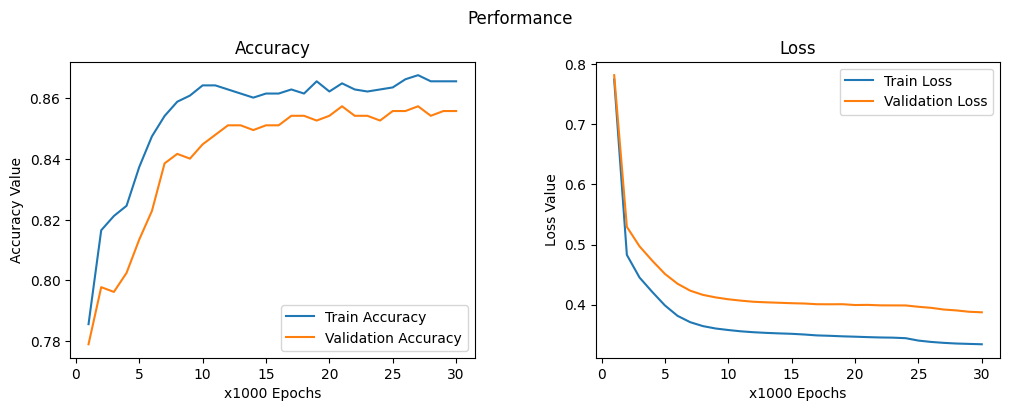

In [257]:
#Convertir en numpy
mlp_np = numpyConvert(tensor_acc_loss)
plotAccLoss(EPOCH//1000, mlp_np[0], mlp_np[1], mlp_np[2], mlp_np[3])

<span style="color:#483D8B;"> Avec un **Multi-Layer Perceptron** à deux couches cachées tel que calui ci dessus, au bout de 30000 itérations, ni la *loss* ni l'*accuracy* n'atteint un maximum clair (du moins marqué par un surapprentissage par la suite). L'*accuracy* maximale est d'environ 0.85.   </span>

### **6. Conclusion**

Pour le jeu de données sur lequel nous avons travaillé, **XGBoost** a été le modèle plus performant pour classer les données des cadiotocogrammes et prédire une maladie foetale. Bien sûr, ces résultats sont limités aux modèles testés. Pour améliorer ces modèle on pourra alors augmenter le nombre de données d'entrainement,la complexité de ces modèles et l'ajustement de leurs paramètres. Dans le domaine médicale, le machine learning peut être utile mais une performances plus importante est nécessaire pour assurer leur fiabilité et choisir les traitements administrés en conséquence.